<a href="https://colab.research.google.com/github/Jeong-ki-hun/Section2_Project/blob/main/%08AI_11_%EC%A0%95%EA%B8%B0%ED%9B%88(Section2_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders
!pip install shap

# 라이브러리 호출

In [356]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('font', family='NanumBarunGothic') 
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import shap
from sklearn.linear_model import ElasticNetCV

In [357]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1) 데이터 선정 이유 및 문제 정의**

문제 정의

중고자동차 시장이 늘어나며 점점 허위매물또한 급증하고있는 추세이다.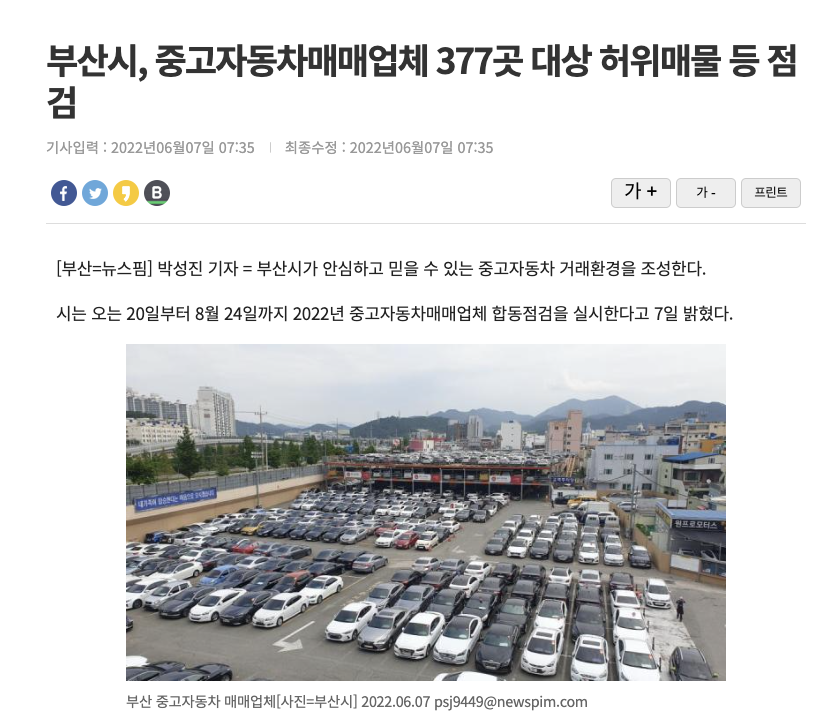

## 데이터는 캐글의 중고차데이터세트를 활용하였습니다.

컬럼설명


brand : 브랜드

model : 자동차 모델

year : 년식


transmission : 변속기


mileage : 주행거리


fuelType : 연료종류


tax : 세금


mpg : 연비


engineSize : 엔진사이즈


price:가격



출처 : https://www.kaggle.com/datasets/kukuroo3/used-car-price-dataset-competition-format?select=X_test.csv



In [358]:
x_te = pd.read_csv('/content/drive/MyDrive/archive (14)/X_test.csv',encoding='cp949')
x_tr = pd.read_csv('/content/drive/MyDrive/archive (14)/X_train.csv',encoding='cp949')
y_tr = pd.read_csv('/content/drive/MyDrive/archive (14)/y_train.csv',encoding='cp949')
y_te = pd.read_csv('/content/drive/MyDrive/archive (14)/y_test.csv',encoding='cp949')
tr = pd.merge(x_tr,y_tr,how='inner',on='carID')
ts = pd.merge(x_te,y_te,how='inner',on='carID')
df = pd.concat([tr,ts]).reset_index(drop=True)

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7632 entries, 0 to 7631
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         7632 non-null   int64  
 1   brand         7632 non-null   object 
 2   model         7632 non-null   object 
 3   year          7632 non-null   int64  
 4   transmission  7632 non-null   object 
 5   mileage       7632 non-null   int64  
 6   fuelType      7632 non-null   object 
 7   tax           7632 non-null   float64
 8   mpg           7632 non-null   float64
 9   engineSize    7632 non-null   float64
 10  price         7632 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 656.0+ KB


In [360]:
df.isnull().sum()

carID           0
brand           0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

In [389]:
df.columns

Index(['brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize', 'price'],
      dtype='object')

# EDA

컬럼설명

In [362]:
df.drop(columns=['carID'],axis=1,inplace=True)

In [363]:
df.corr()

,year,mileage,tax,mpg,engineSize,price
year,1.000000,-0.753325,-0.200159,-0.040006,0.032041,0.498388
mileage,-0.753325,1.000000,0.124939,0.075106,-0.018777,-0.486950
tax,-0.200159,0.124939,1.000000,-0.311065,0.456532,0.142273
mpg,-0.040006,0.075106,-0.311065,1.000000,-0.353857,-0.178982
engineSize,0.032041,-0.018777,0.456532,-0.353857,1.000000,0.623995
price,0.498388,-0.486950,0.142273,-0.178982,0.623995,1.000000


In [364]:
target = df['price']
features = df.drop(columns=['price'],axis=1)

In [365]:
features

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2
1,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0
2,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9
3,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0
4,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0
...,...,...,...,...,...,...,...,...,...
7627,audi,A7,2015,Semi-Auto,21100,Petrol,325.0,29.7,4.0
7628,merc,CLS Class,2015,Automatic,60972,Diesel,160.0,52.3,3.0
7629,ford,Puma,2020,Manual,4111,Petrol,145.0,50.4,1.0
7630,merc,CLA Class,2016,Automatic,25726,Petrol,200.0,41.5,2.0


In [366]:
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)

In [367]:
x_train.columns

Index(['brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

In [385]:
encoder = OneHotEncoder()
x_train_encoded = encoder.fit_transform(x_train)
x_test_encoded = encoder.transform(x_test)
x_train_encoded.head(3)

,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,model_1,...,transmission_4,mileage,fuelType_1,fuelType_2,fuelType_3,fuelType_4,fuelType_5,tax,mpg,engineSize
216,1,0,0,0,0,0,0,0,0,1,...,0,22922,1,0,0,0,0,160.0,48.7,2.0
4381,0,1,0,0,0,0,0,0,0,0,...,0,8991,1,0,0,0,0,260.0,33.2,2.0
6891,1,0,0,0,0,0,0,0,0,1,...,0,13260,1,0,0,0,0,160.0,48.7,2.0


In [369]:
model = Lasso(alpha=1.0)

In [370]:
model.fit(x_train_encoded, y_train)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.973e+10, tolerance: 1.631e+08


Lasso()

In [371]:
print(model.score(x_train_encoded, y_train)) #

print(model.score(x_test_encoded, y_test)) #0.7739730315245023

0.8799461187843136
0.8812519850992345


In [372]:
model.predict(x_val)

X does not have valid feature names, but Lasso was fitted with feature names


array([-611443.48896139])

In [373]:
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train_encoded)
x_test_s = scaler.transform(x_test_encoded)

In [374]:
x_train_s

array([[ 2.29380436, -0.41907163, -0.43675488, ...,  0.10799032,
        -0.04481878, -0.15223239],
       [-0.43595697,  2.38622693, -0.43675488, ...,  1.36808378,
        -0.48163017, -0.15223239],
       [ 2.29380436, -0.41907163, -0.43675488, ...,  0.10799032,
        -0.04481878, -0.15223239],
       ...,
       [-0.43595697, -0.41907163, -0.43675488, ..., -0.0810237 ,
        -0.17445313, -0.80151195],
       [-0.43595697, -0.41907163, -0.43675488, ..., -0.0810237 ,
        -0.43372182,  1.14632672],
       [ 2.29380436, -0.41907163, -0.43675488, ...,  2.18714454,
        -0.60562824,  0.23733534]])

In [377]:
x_val = [['hyundi','Santa Fe',2019,'Semi-Auto',4223,'Diesel',145.0,39.8,2.2]]

In [378]:
x_val

[['hyundi', 'Santa Fe', 2019, 'Semi-Auto', 4223, 'Diesel', 145.0, 39.8, 2.2]]

In [379]:
x_val = pd.DataFrame(x_val, columns=['brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'])

In [380]:
x_val

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2


In [381]:
x_val = trans.transform(x_val)

In [382]:
y_predict= model.predict(x_val)

X does not have valid feature names, but Lasso was fitted with feature names


In [383]:
y_predict

array([-611443.48896139])

ValueError: ignored

In [ ]:
print('검증세트 정확도', logistic.score(x_test, y_test))

In [ ]:
y_predict= logistic.predict(x_val)
print(y_predict[0])

In [388]:
DecisionTree = DecisionTreeClassifier(criterion="entropy",random_state=2,max_depth=5)

DecisionTree.fit(x_train_encoded,y_train)

predicted_values = DecisionTree.predict(x_test_encoded)
x = metrics.accuracy_score(y_test, predicted_values)
acc.append(x)
model.append('Decision Tree')

print("Decision Tree Accuracy : ", x*100, "%")

NameError: ignored